# Simple CoNGA pipeline

This should be roughly equivalent to running the two commands:

**SETUP:**
```
python scripts/setup_10x_for_conga.py --filtered_contig_annotations_csvfile ./conga_datasets/raw/vdj_v1_hs_pbmc_t_filtered_contig_annotations.csv --organism human --output_clones_file tmp_hs_pbmc_clones.tsv
```

**ANALYSIS:**
```
python scripts/run_conga.py --gex_data ./conga_datasets/raw/vdj_v1_hs_pbmc_5gex_filtered_gene_bc_matrices_h5.h5 --gex_data_type 10x_h5 --clones_file tmp_hs_pbmc_clones.tsv --organism human --graph_vs_graph --outfile_prefix tmp_hs_pbmc 
```

In [1]:
%matplotlib inline

import scanpy as sc
import conga
#import conga.tc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from conga.tcrdist.make_10x_clones_file import make_10x_clones_file

## Input data, output paths

In [2]:
# you might have to change these paths depending on what you want to analyze
gex_datafile = './conga_datasets/raw/vdj_v1_hs_pbmc_5gex_filtered_gene_bc_matrices_h5.h5'
gex_datatype = '10x_h5' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
tcr_datafile = './conga_datasets/raw/vdj_v1_hs_pbmc_t_filtered_contig_annotations.csv'
organism = 'human'

clones_file = 'tmp_hs_pbmc_clones.tsv'
outfile_prefix = 'tmp_hs_pbmc'


## Setup for conga: make a TCRdist clones_file and compute kernel PCs

In [3]:
# this creates the TCRdist 'clones file'

make_10x_clones_file( tcr_datafile, organism, clones_file )

# this command will create another file with the kernel PCs for subsequent reading by conga
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file( clones_file, organism )

ab_counts: [((1, 1), 2138), ((2, 1), 169), ((1, 2), 77), ((2, 2), 11), ((3, 3), 1), ((4, 2), 1), ((1, 3), 1), ((3, 2), 1)]
old_num_barcodes: 2422 new_num_barcodes: 2307
compute tcrdist distance matrix for 2144 clonotypes
running KernelPCA (2144, 2144)
writing TCRdist kernel PCs to outfile: tmp_hs_pbmc_clones_AB.dist_50_kpcs


## Read the data, create a scanpy AnnData object with everything inside

In [4]:
adata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file )

# store the organism info in adata
adata.uns['organism'] = organism

adata

reading: ./conga_datasets/raw/vdj_v1_hs_pbmc_5gex_filtered_gene_bc_matrices_h5.h5 of type 10x_h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


total barcodes: 7726 (7726, 33694)
reading: tmp_hs_pbmc_clones.tsv
reading: tmp_hs_pbmc_clones_AB.dist_50_kpcs
Reducing to the 2287 barcodes (out of 7726) with paired TCR sequence data


AnnData object with n_obs × n_vars = 2287 × 33694 
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq'
    var: 'gene_ids'
    uns: 'organism'
    obsm: 'X_pca_tcr'

Note that the AnnData object contains the TCR sequence information in the `obs` array, stored with the  `['va',..., 'cdr3b_nucseq']` fields.

It also contains the TCRdist kernel PCS in the `obsm` array stored under the key `'X_pca_tcr'`

In [5]:
# top 50 TCRdist kPCS 
adata.obsm['X_pca_tcr'].shape

(2287, 50)

In [6]:
# CDR3-alpha regions:
adata.obs['cdr3a'].head(3)

AAACCTGAGTCTTGCA-1       CAQSDSNYQLIW
AAACCTGCAGATGGGT-1         CAVLTNDMRF
AAACCTGTCCTTGCCA-1    CATDFNTGANSKLTF
Name: cdr3a, dtype: object

## Do some very basic scGEX filtering

You could customize this or replace it with something else entirely.

In [7]:
adata = conga.preprocess.filter_and_scale( adata )

filtered out 643 cells with more than 2000 genes
filtered out 14 cells with more than 0.1 percent mito
unable to find feature_types varname
Index(['FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4',
       'RP11-206L10.9', 'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       ...
       'MT-ND6', 'MT-CYB', 'AC145212.4', 'AC145212.2', 'AC011043.1',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=15516)


... storing 'va' as categorical
... storing 'ja' as categorical
... storing 'cdr3a' as categorical
... storing 'cdr3a_nucseq' as categorical
... storing 'vb' as categorical
... storing 'jb' as categorical
... storing 'cdr3b' as categorical
... storing 'cdr3b_nucseq' as categorical


excluding 115 TR genes (89 variable)
excluding 1 sexlinked genes
total of 1324 variable genes (1630, 15516)


## Now we reduce to a single cell per TCR clonotype

Do this by computing GEX distances and picking the most representative cell for each clonotype (the one with the smallest average distance to all other cells in the clonotype)

In [8]:
adata = conga.preprocess.reduce_to_single_cell_per_clone( adata )

adata

compute pca to find rep cell for each clone (1630, 1324)
num_clones: 1539
Normalize and logging matrix...
unable to find feature_types varname
Index(['HES4', 'TNFRSF4', 'RP3-395M20.12', 'MEGF6', 'ACOT7', 'RP1-202O8.3',
       'RP11-312B8.1', 'UTS2', 'TNFRSF9', 'SPSB1',
       ...
       'PKNOX1', 'AP001055.6', 'ITGB2', 'ITGB2-AS1', 'COL18A1', 'COL6A1',
       'COL6A2', 'C21orf58', 'S100B', 'MT-ND6'],
      dtype='object', length=1324)
found 489 of 512 good_genes in var_names  organism=human
reduce from 1630 cells to 1539 cells (one per clonotype)
normalize_and_log_the_raw_matrix:: matrix is already logged


AnnData object with n_obs × n_vars = 1539 × 1324 
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'organism', 'pca', 'raw_matrix_is_logged', 'X_igex_genes'
    obsm: 'X_pca_tcr', 'X_igex'
    varm: 'PCs'

## Now that we've reduced to a single cell per clonotype, run clustering and dimensionality reduction for GEX and for TCR

In [9]:
adata = conga.preprocess.cluster_and_tsne_and_umap( adata )


ran louvain clustering: louvain_gex
oldshape (1539, 2)
ran louvain clustering: louvain_tcr


In [10]:
adata

AnnData object with n_obs × n_vars = 1539 × 1324 
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'louvain_gex', 'clusters_gex', 'louvain_tcr', 'clusters_tcr'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'organism', 'pca', 'raw_matrix_is_logged', 'X_igex_genes', 'neighbors', 'louvain'
    obsm: 'X_pca_tcr', 'X_igex', 'X_pca', 'X_pca_gex', 'X_umap_gex', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_2d'
    varm: 'PCs'

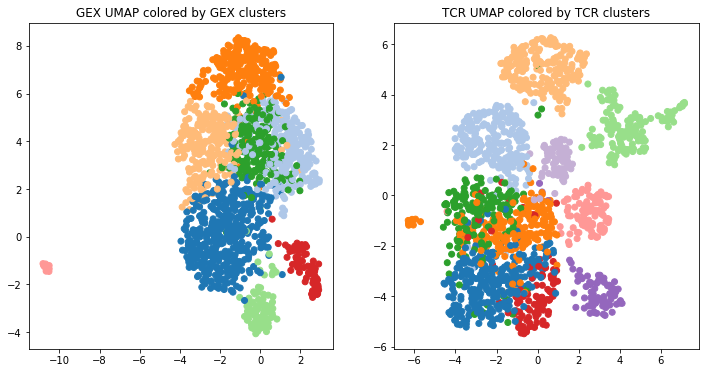

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
clusters = np.array(adata.obs['clusters_gex'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('GEX UMAP colored by GEX clusters')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
clusters = np.array(adata.obs['clusters_tcr'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('TCR UMAP colored by TCR clusters');



## Compute the GEX and TCR neighbor sets

Also do a bit of other miscellaneous setup

In [12]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists)

# stash these in obs array, they are used in a few places...                                                                                                                
adata.obs['nndists_gex'] = nndists_gex
adata.obs['nndists_tcr'] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata) #stores in adata.uns                                                                                                        


compute D_gex 1539
compute D_tcr 1539
argpartitions: 0.01 1539
calculate nndists: 0.01
DONE calculating nndists: 0.01
argpartitions: 0.1 1539
setup_tcr_cluster_names: ['0', '1_AV8', '2', '3_AV14++', '4', '5_BV20', '6_AV12', '7_AV26', '8_AV1', '9_AV9']


## Run graph-vs-graph analysis

In [13]:
results = conga.correlations.run_graph_vs_graph(adata, all_nbrs)

conga_scores = adata.obs['conga_scores']

good_mask = ( conga_scores <= 1.0 )
adata.obs['good_score_mask'] = good_mask

print(f'found {np.sum(good_mask)} conga hits')

results.sort_values('conga_score', inplace=True)

results.head(3)

find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
found 104 conga hits


/home/pbradley/gitrepos/conga/conga/correlations.py:237: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  results_df = pd.concat(all_results, ignore_index=True)


,clone_index,cluster_size,conga_score,mait_fraction,nbr_frac,num_neighbors,num_neighbors_gex,num_neighbors_tcr,overlap,overlap_corrected,overlap_type
190,35,96.0,1.439388e-52,0.9,0.1,153.0,NaN,NaN,70,57,cluster_nbr
232,83,96.0,1.439388e-52,0.9,0.1,153.0,NaN,NaN,70,57,cluster_nbr
230,80,96.0,1.439388e-52,0.9,0.1,153.0,NaN,NaN,70,57,cluster_nbr


### Write the results to a file

In [14]:
# write the results to a tsv file
clusters_gex = np.array(adata.obs['clusters_gex'])
clusters_tcr = np.array(adata.obs['clusters_tcr'])

indices = results['clone_index']
results['gex_cluster'] = clusters_gex[indices]
results['tcr_cluster'] = clusters_tcr[indices]
for tag in 'va ja cdr3a vb jb cdr3b'.split():
    results[tag] = list(adata.obs[tag][indices])
tsvfile = outfile_prefix+'_graph_vs_graph_hits.tsv'
print('saving graph-vs-graph results to file:',tsvfile)

results.to_csv(tsvfile, sep='\t', index=False)


saving graph-vs-graph results to file: tmp_hs_pbmc_graph_vs_graph_hits.tsv


### Make a scatterplot colored by conga score

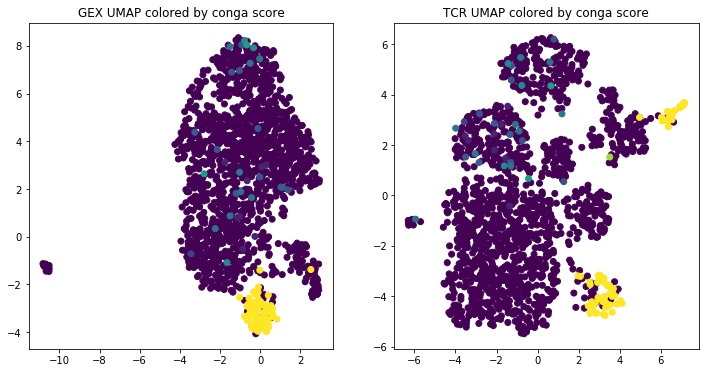

In [15]:
#put the conga hits on top
colors = np.sqrt(np.maximum(-1*np.log10(conga_scores),0.0))
reorder = np.argsort(colors)

plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('GEX UMAP colored by conga score')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('TCR UMAP colored by conga score');


## Make the bicluster logo plots

[((5, 8), 47), ((5, 5), 22), ((0, 1), 12), ((2, 3), 9), ((4, 1), 5), ((1, 1), 3), ((3, 1), 3), ((6, 8), 1), ((5, 2), 1), ((3, 9), 1)]
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']


... storing 'test' as categorical


[((5, 8), 47), ((5, 5), 22), ((0, 1), 12), ((2, 3), 9), ((4, 1), 5), ((1, 1), 3), ((3, 1), 3), ((6, 8), 1), ((5, 2), 1), ((3, 9), 1)]
run rank_genes_groups [('none', 1444), ('clp_5_8', 47), ('clp_5_5', 22), ('clp_0_1', 12), ('clp_2_3', 9), ('clp_4_1', 5)]
clp: 0 5 tmp_hs_pbmc_bicluster_logos.png
clp: 1 5 tmp_hs_pbmc_bicluster_logos.png
clp: 2 5 tmp_hs_pbmc_bicluster_logos.png
clp: 3 5 tmp_hs_pbmc_bicluster_logos.png
clp: 4 5 tmp_hs_pbmc_bicluster_logos.png


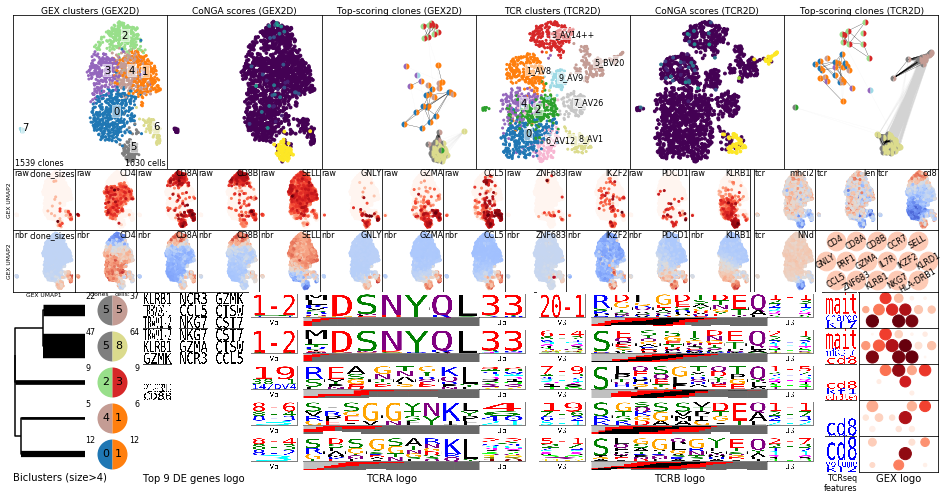

In [16]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

# calc tcr sequence features of good cluster pairs
good_bicluster_tcr_scores = conga.correlations.calc_good_cluster_tcr_features(
    adata, good_mask, clusters_gex, clusters_tcr, conga.tcr_scoring.all_tcr_scorenames, verbose=False,
    min_count=min_cluster_size)

# run rank_genes on most common biclusters
rank_genes_uns_tag = 'rank_genes_good_biclusters'
conga.correlations.run_rank_genes_on_good_biclusters(
    adata, good_mask, clusters_gex, clusters_tcr, min_count=min_cluster_size, key_added= rank_genes_uns_tag)

gex_header_tcr_score_names = ['mhci2', 'cdr3len', 'cd8', 'nndists_tcr']

logo_pngfile = outfile_prefix+'_bicluster_logos.png'

conga.plotting.make_logo_plots(
    adata, nbrs_gex, nbrs_tcr, min_cluster_size, logo_pngfile,
    good_bicluster_tcr_scores=good_bicluster_tcr_scores,
    rank_genes_uns_tag = rank_genes_uns_tag,
    gex_header_tcr_score_names = gex_header_tcr_score_names )


### The image that was saved to disk is higher resolution than the one above here in the notebook 
This should be the one on disk, below. You could try opening it in a new tab, to see the full resolution...
![hey](tmp_hs_pbmc_bicluster_logos.png)

## Run graph-vs-feature analysis, comparing the TCR graph to GEX features (mostly gene expression)

finding biased GEX features for nbrhoods with size 0.01 (1539, 15)


/home/pbradley/anaconda2/envs/scanpy_new/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/pbradley/anaconda2/envs/scanpy_new/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/pbradley/anaconda2/envs/scanpy_new/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/pbradley/gitrepos/conga/conga/correlations.py:576: RuntimeWarning: invalid value encountered in sqrt
  mean2=mean_bg, std2=np.sqrt(np.hstack([var_bg, var2_fg])), nobs2=num_clones-num_fg,


finding biased GEX features for nbrhoods with size 0.1 (1539, 153)


/home/pbradley/gitrepos/conga/conga/correlations.py:575: RuntimeWarning: invalid value encountered in sqrt
  mean1=mean_fg, std1=np.sqrt(np.hstack([var_fg, var2_fg])), nobs1=num_fg,


making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features.tsv
making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features.png


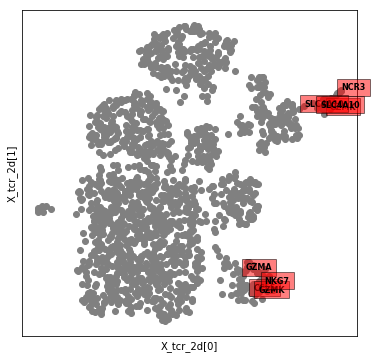

In [17]:
pval_threshold = 1.
results = []
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    print('finding biased GEX features for nbrhoods with size', nbr_frac, nbrs_gex.shape)
    results.append( conga.correlations.tcr_nbrhood_rank_genes_fast( adata, nbrs_tcr, pval_threshold, verbose=False))
    results[-1]['nbr_frac'] = nbr_frac

# save the results to a file
tsvfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.tsv'
print('making:', tsvfile)
results_df = pd.concat(results, ignore_index=True)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.png'
print('making:', pngfile)
conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_tcr_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile)

### Plot the top GEX features on the TCR UMAP landscape

making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features_panels.png
GZMK
SLC4A10
KLRB1
CST7
NKG7
NCR3
GZMA
CCL5


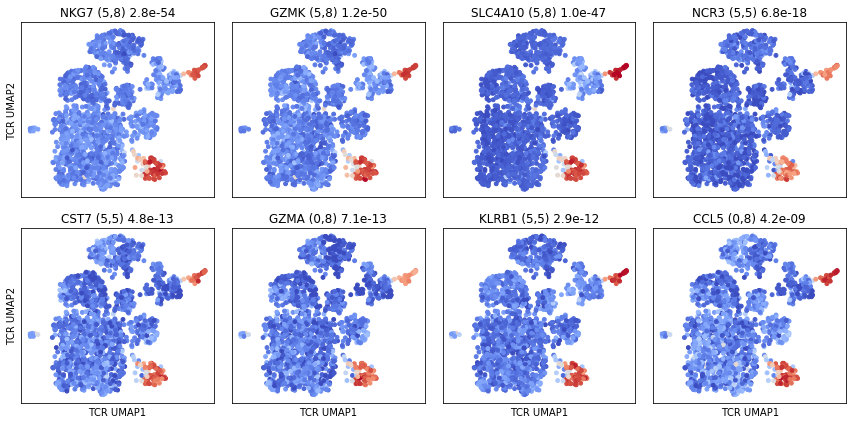

In [18]:
pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'tcr', all_nbrs, results_df, pngfile)

## Run graph-vs-features analysis, comparing the GEX graph to TCR features

making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features.tsv
making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features.png


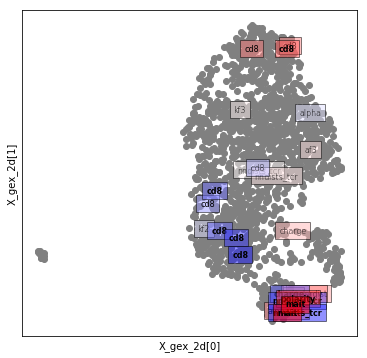

In [19]:
pval_threshold = 1.
results = []
tcr_score_names = conga.tcr_scoring.all_tcr_scorenames # the TCR features to use
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    results.append( conga.correlations.gex_nbrhood_rank_tcr_scores(
        adata, nbrs_gex, tcr_score_names, pval_threshold, verbose=False ))
    results[-1]['nbr_frac'] = nbr_frac
results_df = pd.concat(results, ignore_index=True)

tsvfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.tsv'
print('making:', tsvfile)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.png'
print('making:', pngfile)

conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_gex_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile,
    direction_column='ttest_stat')

### Plot the top TCR score hits on the GEX UMAP landscape

making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features_panels.png
polarity
nndists_tcr
charge
kf7
cd8
mjenergy
kf4
mait
alphadist


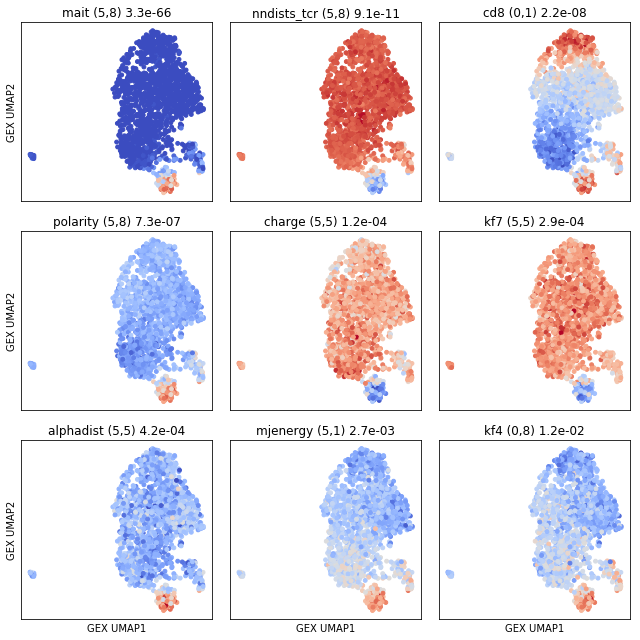

In [20]:
pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'gex', all_nbrs, results_df, pngfile)